<img src="../images/logo_VORTEX.png" width="200" height="auto" alt="Company Logo">

| Project| Authors           | Company                                 | Year | Chapter |
|--------|-------------------|-----------------------------------------|------|---------|
| Pywind | Oriol L           | [Vortex FdC](https://www.vortexfdc.com) | 2025 | 4       |

# Chapter 4: Basic Plots

_Overview_

In this chapter, we will build upon the previous chapter, where we learned how to read and preprocess the data. Here, we will focus on visualizing the data through various plots to gain deeper insights. We've gone with matplotlib.pyplot library although some others like seaborn are nice too.

_Specifically, we will:_

- Create an XY plot to identify potential outliers and observe correlation and XY dispersion.
- Generate histograms to analyze the distribution of key variables.
- Plot a direction histogram to examine wind direction patterns.
- Visualize the daily cycle to understand diurnal variations.
- Explore the yearly cycle and interannual variability to identify seasonal and long-term trends.

Additionally, we will examine the concurrent period with missing data (nodatas) and assess how these gaps can impact overall statistics. This analysis will help us better understand the quality and reliability of the dataset. 

_Tunable..._

The plot function are tunable so you can play with the parameters.
Additionally you can change the variables in the begining section to analyse different variables or even some other relationship with different variables.

_What you'll learn_

By the end of this chapter, you will have an overview of wind data most relevant with visual information which will be complimentary to the statistics derived in previous chapters.

You will also have access to other variables inspection with basic plots like XY, histogram and different temporal averages.

### Import Libraries

In [36]:
import sys
import os
import pandas as pd
sys.path.append(os.path.join(os.getcwd(), '../examples'))
from example_3_merge_functions import *
from example_4_basic_plots_functions import *

###  Define Paths and Site

In [37]:
SITE = 'froya'
pwd = os.getcwd()
base_path = str(os.path.join(pwd, '../data'))
output_dir = "output"

###  Repeat the process in chapter 3 to read netcdf and merge datasets

We repeat the precess from previous chapter. You can anyway alter this to load and analyse other variables. Or you can subset the datasets for certain episodes, periods or even variable conditioning. We'll work on this anyway in following chapters.

In [ ]:
measurements_netcdf = os.path.join(base_path, f'{SITE}/measurements/obs.nc')
vortex_netcdf = os.path.join(base_path, f'{SITE}/vortex/SERIE/vortex.serie.era5.utc0.nc')

vortex_txt = os.path.join(base_path, f'{SITE}/vortex/SERIE/vortex.serie.era5.utc0.100m.txt')
measurements_txt = os.path.join(base_path, f'{SITE}/measurements/obs.txt')

# Print filenames
print('Measurements NetCDF: ', measurements_netcdf)
print('Vortex NetCDF: ', vortex_netcdf)

# Read NetCDF
ds_obs_nc = xr.open_dataset(measurements_netcdf)
ds_vortex_nc = xr.open_dataset(vortex_netcdf)
#ds_vortex_nc = ds_vortex_nc.rename_vars({'D': 'Dir'})

# Interpolate Vortex Series to the same Measurements level. Select M and Dir.
max_height = ds_obs_nc.squeeze().coords['lev'].max().values
print("Max height in measurements: ", max_height)
ds_obs_nc = ds_obs_nc.sel(lev=max_height).squeeze().reset_coords(drop=True)[['M', 'Dir']]
ds_vortex_nc = ds_vortex_nc.interp(lev=max_height).squeeze().reset_coords(drop=True)[['M', 'Dir']]

# convert ds_obs_nc to hourly
ds_obs_nc = ds_obs_nc.resample(time='1h').mean()

# Convert all to DataFrame, Rename and Merge

df_obs_nc = ds_obs_nc.to_dataframe()
df_vortex_nc = ds_vortex_nc.to_dataframe()

# rename columns so they do now have the same name when merging
df_obs_nc.columns = ['M_obs_nc', 'Dir_obs_nc']
print("df_obs_nc columns: ", df_obs_nc.columns)
df_vortex_nc = df_vortex_nc[['M','Dir']]
print("df_vortex_nc columns: ", df_vortex_nc.columns)
df_vortex_nc.columns = ['M_vortex_nc', 'Dir_vortex_nc']

df = df_vortex_nc.merge(df_obs_nc, left_index=True, right_index=True)
df = df.dropna(how='any', axis=0)

Measurements NetCDF:  /home/oriol/vortex/git/pywind/notebooks/../data/froya/measurements/obs.nc
Vortex NetCDF:  /home/oriol/vortex/git/pywind/notebooks/../data/froya/vortex/SERIE/vortex.serie.era5.utc0.nc
Max height in measurements:  100.0
df_obs_nc columns:  Index(['M_obs_nc', 'Dir_obs_nc'], dtype='object')
df_vortex_nc columns:  Index(['M', 'Dir'], dtype='object')


## XY PLOT: Correlation
 The XY plot compares observed wind speed data (M_obs_nc) with synthetic wind speed data (M_vortex_nc).
 A parameter `outlyer_threshold` is set to identify and mark potential outliers in the data.

 With this plot we can observe how acurate is the relationship of both datasets in the temporal dimension. A good correlation have some benefits:
 - Use for long term correction
 - Reliable use of corrected time series for power computation

And in general any computation that requires a good time matching despite of bias deviations.

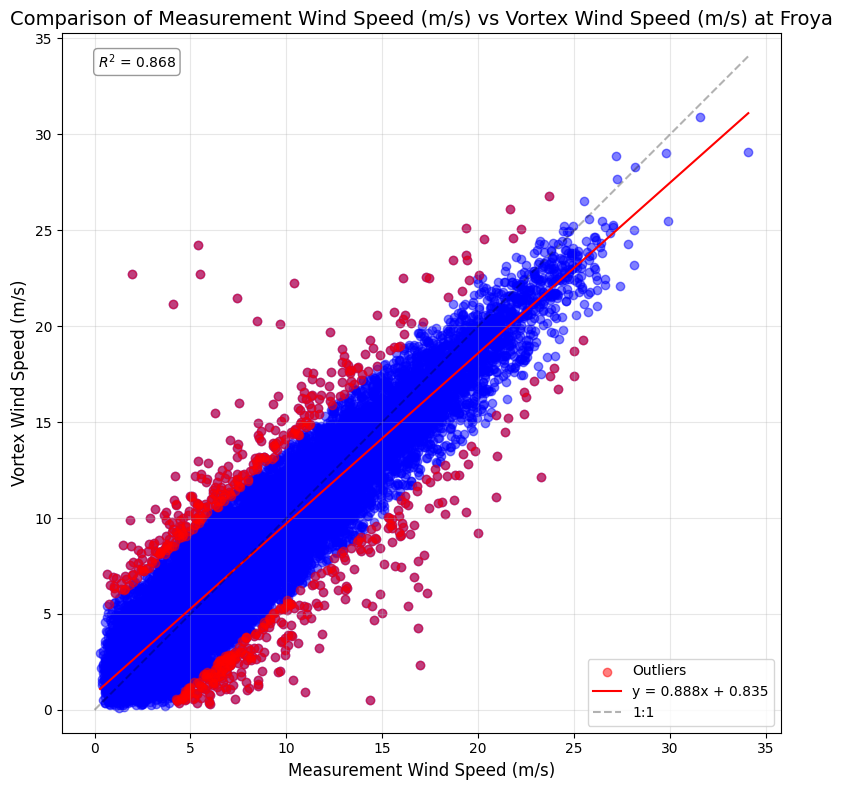

In [39]:
# Use the functions to create the plots
xy_stats = plot_xy_comparison(
    df=df, 
    x_col='M_obs_nc', 
    y_col='M_vortex_nc',
    x_label='Measurement Wind Speed (m/s)',
    y_label='Vortex Wind Speed (m/s)',
    site=SITE,
    output_dir=output_dir,
    outlyer_threshold=4
)


## Threshhold parameter for outlyers identification

In the xy plot we have enabled a threshhold for outlyers modification. It can be modified inside the function for bined parametrization, relative threshold and many more. In this case we are jut using a single absolute value for all the wind speed range:
```python
    # Calculate the expected y values based on regression for each actual x point
    y_expected = slope * df[x_col] + intercept
    y_real= df[y_col]
    df['diff'] = np.abs(y_real - y_expected)
    # Find points with significant differences
    outlyers = df['diff'] > outlyer_threshold
```
So next plot show outlyers for amplied range of threshhold to 6m/s

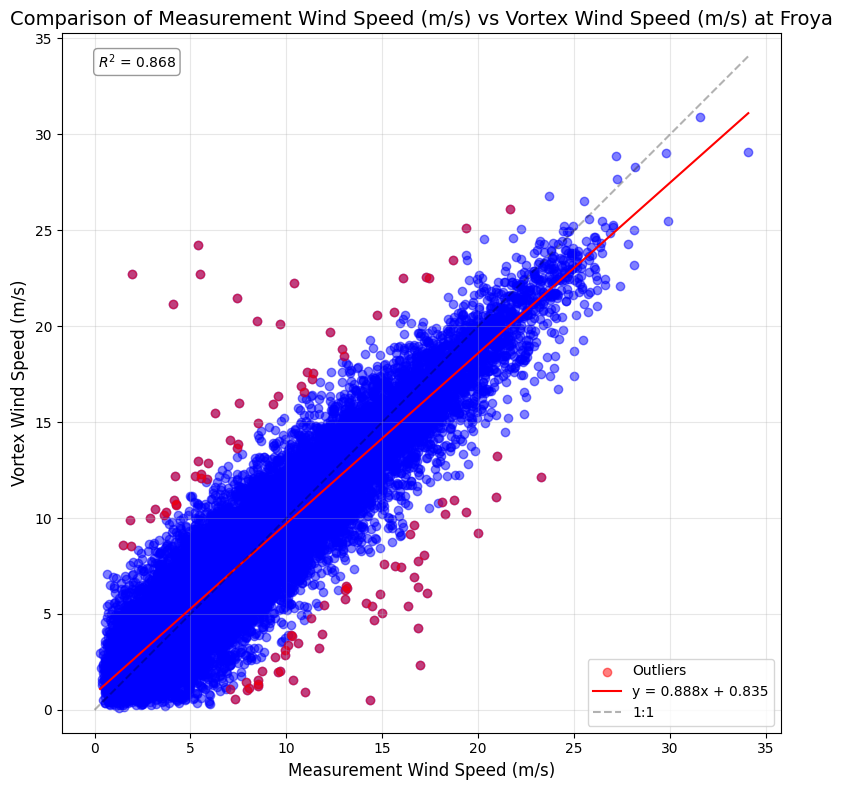

In [40]:

# Use the functions to create the plots
xy_stats = plot_xy_comparison(
    df=df, 
    x_col='M_obs_nc', 
    y_col='M_vortex_nc',
    x_label='Measurement Wind Speed (m/s)',
    y_label='Vortex Wind Speed (m/s)',
    site=SITE,
    output_dir=output_dir,
    outlyer_threshold=6
) 

### XY Correlation statistics
The plot function returns statistcs from the regression.

In [41]:
# Display regression statistics in a formatted way
display(Markdown(f"""
### Regression Statistics:
- **Slope:** {xy_stats['slope']:.4f}
- **Intercept:** {xy_stats['intercept']:.4f}
- **R-squared:** {xy_stats['r_squared']:.4f}
- **p-value:** {xy_stats['p_value']:.4e}
- **Standard Error:** {xy_stats['std_err']:.4f}
"""))


### Regression Statistics:
- **Slope:** 0.8883
- **Intercept:** 0.8349
- **R-squared:** 0.8677
- **p-value:** 0.0000e+00
- **Standard Error:** 0.0020


## Wind speed histogram

The histogram shows the frequency of the wind speed at different ranges. The shape of this histogram can affect:
- The adequaition to Weibull function. This indicates if using weibull parameters for computations is radequated.
- How frequent the extremes and cutoff values are.
- A more accurated approximation to power production despite mean wind speed value.
  
_comparing obs and synthetic data_

The goodness of the shape indicates a lower production computation error for similar correlation and mean wind speed errors. 

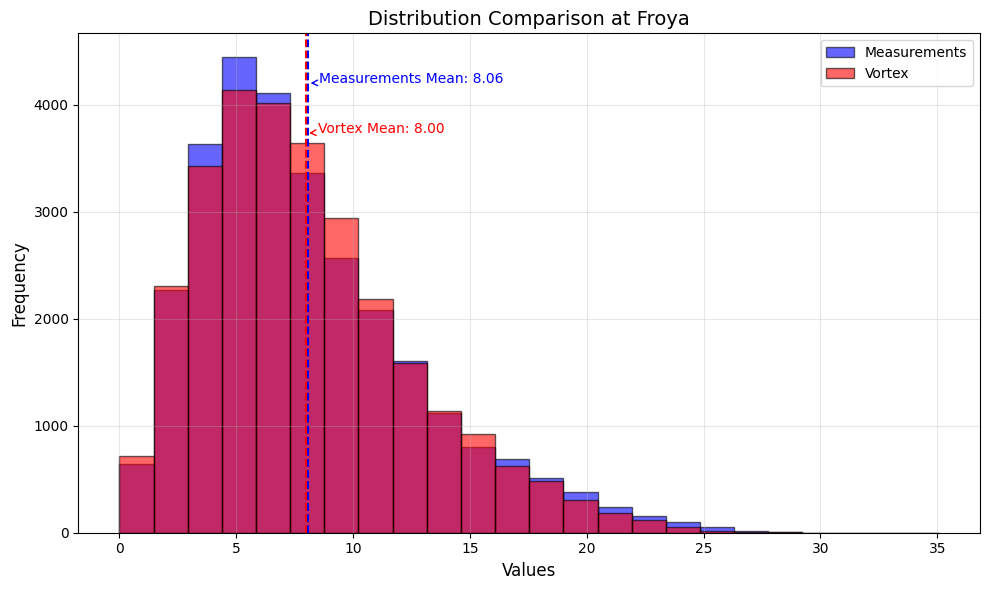

In [42]:

# Create histogram
hist_stats = plot_histogram_comparison(
    df=df,
    cols=['M_obs_nc', 'M_vortex_nc'],
    labels=['Measurements', 'Vortex'],
    colors=['blue', 'red'],
    site=SITE,
    output_dir=output_dir,
    bins=25,
    alpha=0.6
)


## Wind direction histogram

Appart from the wind rose you can use histogram to plot similar information.

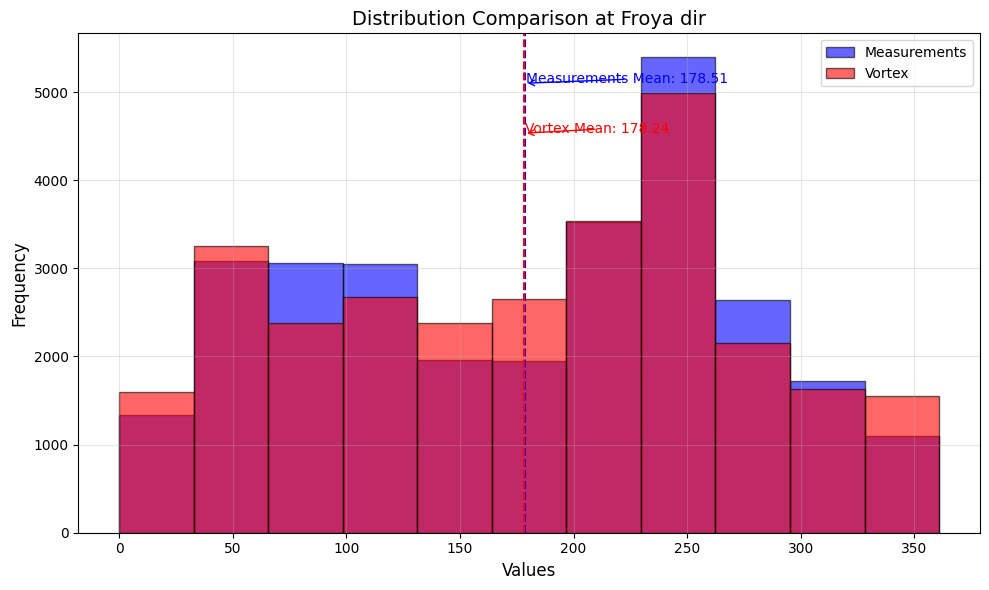

In [43]:
hist_stats = plot_histogram_comparison(
    df=df,
    cols=['Dir_obs_nc', 'Dir_vortex_nc'],
    labels=['Measurements', 'Vortex'],
    colors=['blue', 'red'],
    site=SITE+" Dir",
    output_dir=output_dir,
    bins=12,
    alpha=0.6
)

## Yearly cycle
The monthly means indicates the yearly cycle. This information is valuable to gather the seasonability of the site.


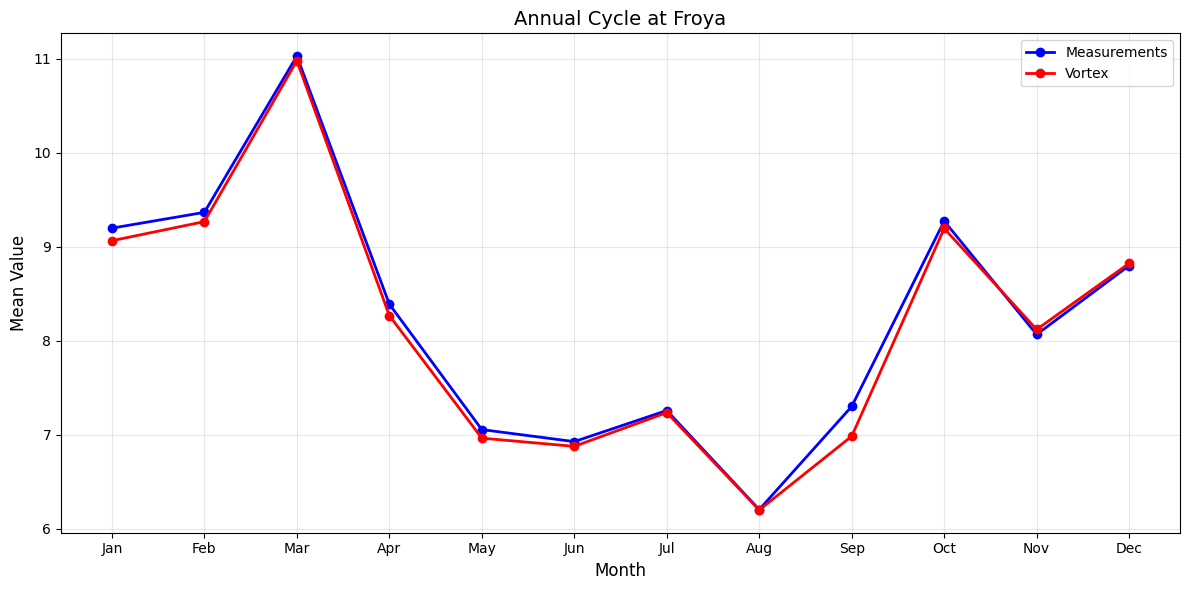

In [44]:
annual_stats_M = plot_annual_means(
    df=df,
    cols=['M_obs_nc', 'M_vortex_nc'],
    labels=['Measurements', 'Vortex'],
    colors=['blue', 'red'],
    site=SITE,
    output_dir=output_dir
)

## Daily cycle
The hourly means indicates how the wind patterns changes during the day. It is important for example to know if it is aligned with consumption or other renewable sources.

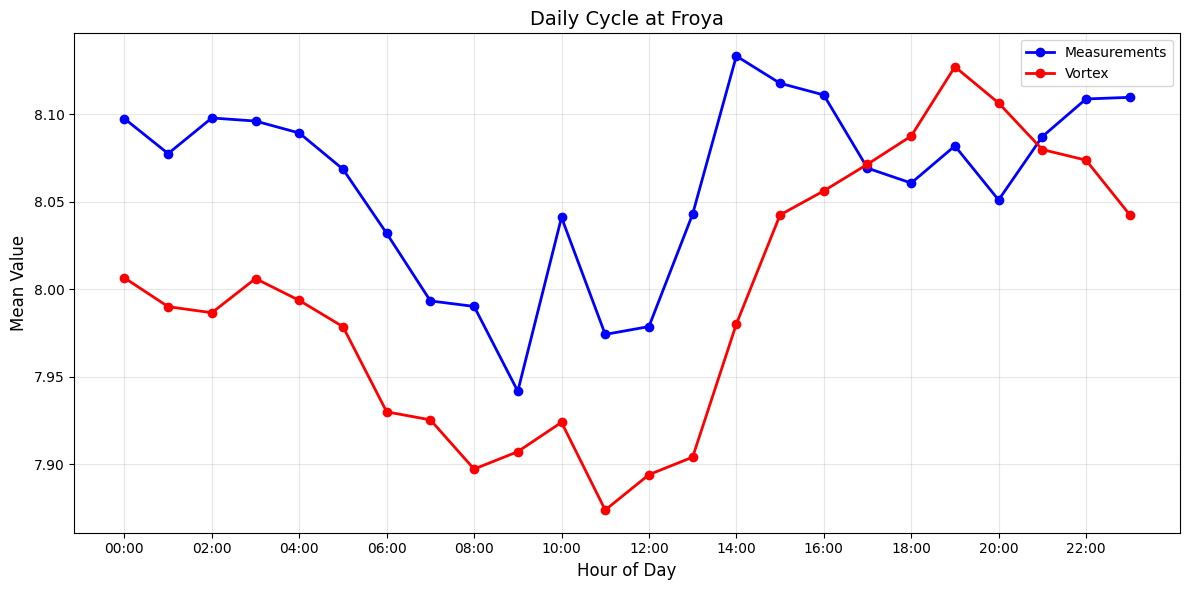

In [45]:
daily_stats_M = plot_daily_cycle(
    df=df,
    cols=['M_obs_nc', 'M_vortex_nc'],
    labels=['Measurements', 'Vortex'],
    colors=['blue', 'red'],
    site=SITE,
    output_dir=output_dir
)

## Interanual variability

The yearly means indicates the climatic variability of a site and underscores how variable a production of a site will be for full years. This period is often related to economic reports which are made yearly.

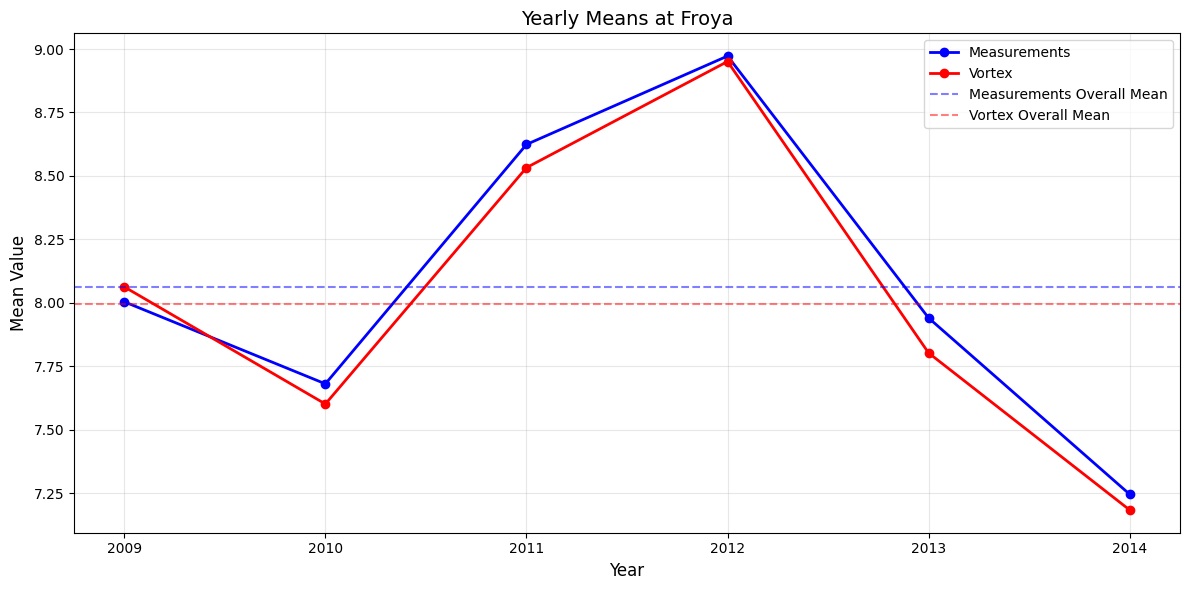

In [46]:
yearly_stats_M = plot_yearly_means(
    df=df,
    cols=['M_obs_nc', 'M_vortex_nc'],
    labels=['Measurements', 'Vortex'],
    colors=['blue', 'red'],
    site=SITE,
    output_dir=output_dir
)

## Long term interanual variability

We have compared the goodness of yearly means bu we want to use Vortex's long term data to get a climateic overview ny using the long term.

So we add the Vortex serie using all of its period, not just the concurrent with measurements.

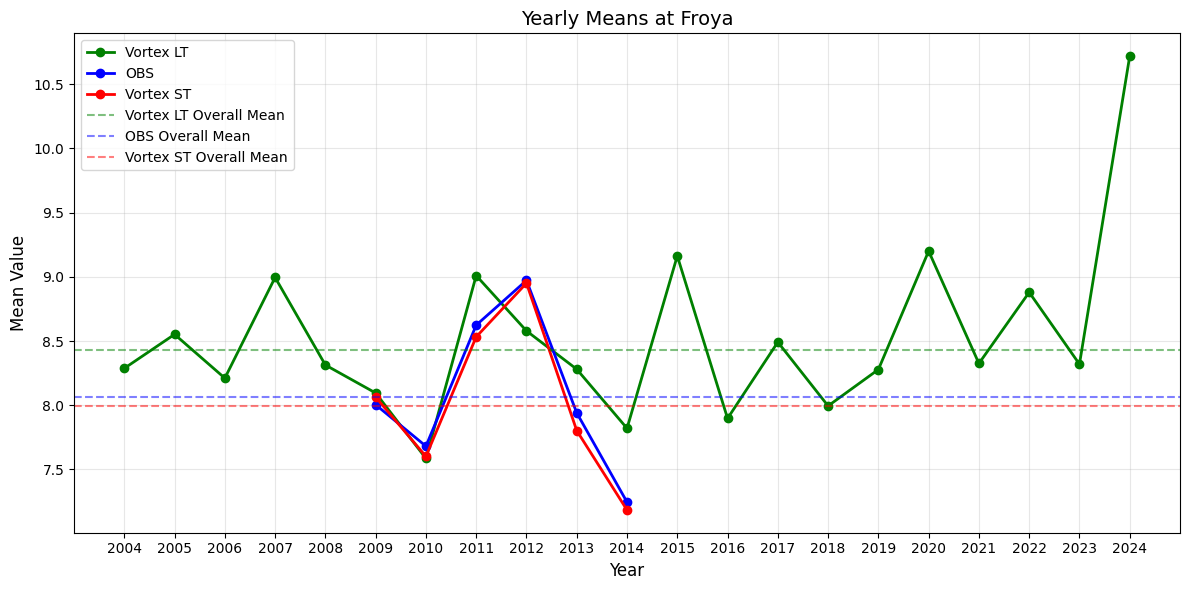

In [47]:
# add vortex series with only concurrent period to obs.
df_with_na = pd.merge(df_vortex_nc, df_obs_nc, left_index=True, right_index=True, how='outer')
df_ST = df[['M_vortex_nc','Dir_vortex_nc']]
df_ST.columns = ['M_vortex_nc_ST', 'Dir_vortex_nc_ST']
df_with_na = pd.merge(df_with_na, df_ST, left_index=True, right_index=True, how='outer')

# now I want to compare long term histogram using full ds_vortex_nc compared to the df period
hist_stats = plot_yearly_means(
    df = df_with_na,
    cols = ['M_vortex_nc','M_obs_nc','M_vortex_nc_ST'],
    labels=['Vortex LT','OBS','Vortex ST'],
    colors=['green','blue','red'],
    site =SITE,
    output_dir=output_dir
)



## Select the concurrent period manually
The same way we can select the concurrent period and compute the statistics and show the number of missing values. This way we observe there are many missing values in measurements which have been also set in the ST Vortex dataset. This is then the reason of the different results observed when using concurrent and non-concurrent timestamps.

In [48]:
from IPython.display import display
display(df_with_na.loc['2010-01-01':'2014-12-31'].describe())
display(df_with_na.loc['2010-01-01':'2014-12-31'].isna().sum())

,M_vortex_nc,Dir_vortex_nc,M_obs_nc,Dir_obs_nc,M_vortex_nc_ST,Dir_vortex_nc_ST
count,43824.000000,43824.000000,27767.000000,27767.000000,27767.000000,27767.000000
mean,8.255428,181.041908,8.062752,178.657698,7.992815,178.118265
std,4.728339,89.081128,4.733560,92.600148,4.519153,94.290157
min,0.102160,0.036450,0.288667,2.166667,0.102160,0.056901
25%,4.741649,110.883193,4.606000,94.541667,4.658041,96.371031
50%,7.410357,191.088562,7.054583,198.166667,7.246005,191.973172
75%,10.772218,245.037025,10.582167,250.000000,10.462807,246.393020
max,33.091569,359.953259,34.078167,358.583333,30.914024,359.953259


M_vortex_nc             0
Dir_vortex_nc           0
M_obs_nc            16057
Dir_obs_nc          16057
M_vortex_nc_ST      16057
Dir_vortex_nc_ST    16057
dtype: int64

## Check the data

So we observe a discrepancy. We make the hypotesis this is due to a number of missing data in the measurements. So we make a quick check by removing nodatas from the merged datased and plot to see LT and ST are aligned.


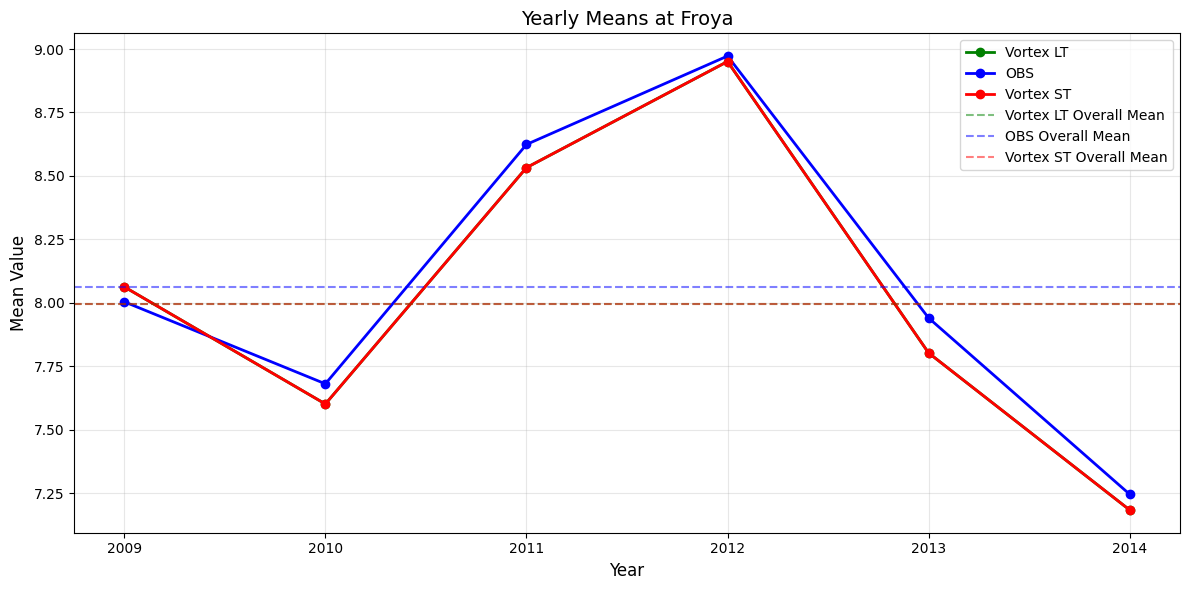

In [49]:
df_with_na = df_with_na.dropna(how='any', axis=0)
hist_stats = plot_yearly_means(
    df = df_with_na,
    cols = ['M_vortex_nc','M_obs_nc','M_vortex_nc_ST'],
    labels=['Vortex LT','OBS','Vortex ST'],
    colors=['green','blue','red'],
    site =SITE,
    output_dir=output_dir
)

### Thank you for completing this Notebook! 
### *Other references available upon request.*

Remember:

- Play loading other variables or subsets of the data at the bening.
- Change the parameters of the plots to gather your desired information.
- Use the plots to check the measurements goodnes and do data cleaning.
- Show other statistics from plots functions.
- Modify the functions fo ryour own desires :-)
- Play with other outlyers threshhold or threshhold functions.

**Don't hesitate to [contact us](https://vortexfdc.com/contact/) for any questions and information.**

## Change Log


| Date (YYYY-MM-DD) | Version | Changed By | Change Description                         |
|-------------------|---------|------------|--------------------------------------------|
| 2025-04-11        | 0.1     | Oriol L    | Notebook creation                          |

<hr>

## <h3 align="center"> © Vortex F.d.C. 2025. All rights reserved. <h3/>